## Cellpose Setup

In [2]:
#!pip install git+https://www.github.com/mouseland/cellpose.git #to install development version
!pip install "cellpose==2.3.2"
!pip install torch torchvision torchaudio
!pip install omnipose

#Fix opencv error: ImportError: cannot import name '_registerMatType' from 'cv2.cv2'
!pip install "opencv-python-headless<4.3"
exit(0) #Restart Runtime to use newly installed numpy
#or may get the error: ValueError: numpy.ndarray size changed, may indicate binary incompatibility. Expected 88 from C header, got 80 from PyObject

#https://stackoverflow.com/questions/8924173/how-do-i-print-bold-text-in-python
BOLD = '\033[1m'
UNDERLINE = '\033[4m'
END = '\033[0m'
print("\n"+BOLD+UNDERLINE+"Restarting the RUNTIME. Wait till you see the green tick on the right top, next to RAM and Disk before proceeding."+END)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.9/176.9 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.4/6.4 MB 82.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.3/43.3 MB 27.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 53.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 80.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 84.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.7/56.7 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.5/108.5 kB 8.2 MB/s eta 0:00:00
  Created wheel for omnipose: filename=omnipose-1.0.6-py3-none-any.whl size=345104 sha256=e483c46038bde0e0695294ecfeb3e629c5d1cd6b7b24f1a05ac5e61f3caff3a1
  Stored in directory: /root/.cache/pip/wheels/c1/c1/11/6b60ad9e07f9ac4c6678e493d585aa13c2bd85303c0

## Project 2: Code with training & prediction

### Imports

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import os
import random
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from skimage import io, measure
from cellpose import models

### Data Processing & Model setup

In [2]:
# Input Directory and Metadata
input_dir = '/content/drive/MyDrive/STAT5243/Project 2/Data/downsampled_data'

metadata = pd.read_csv('/content/drive/MyDrive/STAT5243/Project 2/Data/metadata_BR00116991.csv')
metadata['FileName_OrigRNA'] = metadata['FileName_OrigRNA'].str[:9] + '.tiff'
# metadata['FileName_OrigRNA'] = metadata['FileName_OrigRNA'].str[13:25]
metadata.head(5)

,Unnamed: 0,FileName_OrigRNA,Metadata_ChannelID,Metadata_Plate,Metadata_Well,Metadata_Site,Metadata_AbsPositionZ,Metadata_PositionX,Metadata_PositionY,Metadata_PositionZ,Metadata_Row,Metadata_target,Metadata_experiment_type,Metadata_cell_line,Metadata_pert_iname,Metadata_gene,Metadata_pubchem_cid
0,0,r01c01f01.tiff,5,BR00116991,A01,1,0.134679,-0.000323,0.000323,-0.000002,1,CACNB4,Compound,A549,gabapentin-enacarbil,NaN,9883933.0
1,1,r01c01f02.tiff,5,BR00116991,A01,2,0.134679,-0.000969,0.000969,-0.000002,1,CACNB4,Compound,A549,gabapentin-enacarbil,NaN,9883933.0
2,2,r01c01f03.tiff,5,BR00116991,A01,3,0.134673,0.000323,0.000969,-0.000002,1,CACNB4,Compound,A549,gabapentin-enacarbil,NaN,9883933.0
3,3,r01c01f04.tiff,5,BR00116991,A01,4,0.134674,0.000969,0.000323,-0.000002,1,CACNB4,Compound,A549,gabapentin-enacarbil,NaN,9883933.0
4,4,r01c01f05.tiff,5,BR00116991,A01,5,0.134681,-0.000969,-0.000323,-0.000002,1,CACNB4,Compound,A549,gabapentin-enacarbil,NaN,9883933.0


In [5]:
# ## METADATA ANALYSIS

# # print(metadata['FileName_OrigRNA'].value_counts())
# print('1. Metadata has 3456 unique RNA filenames for analysis.')
# # print(metadata['Metadata_Plate'].value_counts())
# print('2. Metadata uses the same plate with ID: BR00116991')
# # print(metadata['Metadata_target'].value_counts())
# print('3. Metadata has 160 unique target genes.')
# # print(metadata['Metadata_pert_iname'].value_counts())
# print('4. Metadata has 304 unique pertubations including DMSO(placebo).')
# # print(metadata['Metadata_pubchem_cid'].value_counts())
# print('5. Metadata has 296 unique pubchem ID for the chemical compounds used.')

In [4]:
# print(metadata['Metadata_pert_iname'].unique())
print('There are:', len(metadata['Metadata_target'].unique()), 'unique target genes.')

# print(metadata['Metadata_pert_iname'].unique())
print('There are:', len(metadata['Metadata_pert_iname'].unique()), 'unique pertubations.')

There are: 161 unique target genes.
There are: 304 unique pertubations.


In [6]:
# Create DataFrame metadata_clean
cols = ['FileName_OrigRNA', 'Metadata_target','Metadata_pert_iname','Metadata_Site']
metadata_clean = metadata[cols].copy()
# metadata_clean['FileName_OrigRNA'] = metadata_clean['FileName_OrigRNA'].str[:9] + '.tiff'
# metadata_clean['FileName_OrigRNA'] = metadata_clean['FileName_OrigRNA'].str[:9]
metadata_clean['Metadata_target'] = metadata_clean['Metadata_target'].fillna('Placebo')

metadata_clean.head(110)

,FileName_OrigRNA,Metadata_target,Metadata_pert_iname,Metadata_Site
0,r01c01f01.tiff,CACNB4,gabapentin-enacarbil,1
1,r01c01f02.tiff,CACNB4,gabapentin-enacarbil,2
2,r01c01f03.tiff,CACNB4,gabapentin-enacarbil,3
3,r01c01f04.tiff,CACNB4,gabapentin-enacarbil,4
4,r01c01f05.tiff,CACNB4,gabapentin-enacarbil,5
...,...,...,...,...
105,r01c12f07.tiff,CA5A,ethoxzolamide,7
106,r01c12f08.tiff,CA5A,ethoxzolamide,8
107,r01c12f09.tiff,CA5A,ethoxzolamide,9
108,r01c13f01.tiff,P3H1,ascorbic-acid,1


In [7]:
# Initialize Cellpose model globally to avoid reloading it for every image
model = models.Cellpose(gpu=True, model_type='cyto2')

100%|██████████| 25.3M/25.3M [00:00<00:00, 54.5MB/s]
/usr/local/lib/python3.10/dist-packages/cellpose/resnet_torch.py:235: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  stat

In [8]:
# Extract Features Function
def extract_features_from_image(image_path):
    try:
        # Load the image
        img = io.imread(image_path)

        # Segment using Cellpose
        results = model.eval(img, diameter=None, flow_threshold=0.4, cellprob_threshold=-5)
        masks, *_ = results

        # Extract features from masks
        labeled_masks = measure.label(masks)
        properties = measure.regionprops(labeled_masks)

        # Collect cell-level features
        features = []
        for prop in properties:
            features.append({
                'Area': prop.area,
                'Perimeter': prop.perimeter,
                'Eccentricity': prop.eccentricity
            })

        return features
    except Exception as e:
        print(f"Error processing image {image_path}: {e}")
        return None

# Prepare a single batch of data
def prepare_batch(metadata, input_dir, dmso_count=10, treated_count=10):
    # Split metadata into DMSO and treated
    dmso_metadata = metadata[metadata['Metadata_pert_iname'] == 'DMSO']
    treated_metadata = metadata[metadata['Metadata_pert_iname'] != 'DMSO']

    # Randomly select specified number of images
    dmso_batch = dmso_metadata.sample(n=dmso_count, random_state=42)
    treated_batch = treated_metadata.sample(n=treated_count, random_state=42)

    # Combine batches and shuffle
    batch_metadata = pd.concat([dmso_batch, treated_batch]).sample(frac=1, random_state=42)

    X = []
    y = []

    for _, row in batch_metadata.iterrows():
        image_file = row['FileName_OrigRNA']
        pert_iname = row['Metadata_pert_iname']

        image_path = os.path.join(input_dir, image_file)
        if not os.path.exists(image_path):
            print(f"File not found: {image_path}")
            continue

        # Extract features
        cell_features = extract_features_from_image(image_path)
        if cell_features:
            # Aggregate features across cells
            cell_features_df = pd.DataFrame(cell_features)
            aggregated_features = cell_features_df.mean().to_dict()
            X.append(list(aggregated_features.values()))
            y.append(pert_iname)

    return np.array(X), np.array(y)

### Load the trained model

In [15]:
with open('random_forest_model.pkl', 'rb') as file:
    loaded_model = pickle.load(file)

with open('label_encoder.pkl', 'rb') as file:
    loaded_le = pickle.load(file)

print("Model and LabelEncoder loaded successfully.")

Model and LabelEncoder loaded successfully.


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator LabelEncoder from version 1.4.1.post1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


### Training the Random Forest Model with 'n' images

In [29]:
# # Main Code Execution
# if __name__ == "__main__":
#     batch_size = 20
#     dmso_count = 10
#     treated_count = 10
#     max_samples = 500  # Stop training after this number of samples
#     total_samples = 0

#     all_X = []
#     all_y = []

#     print("Processing in batches...")
#     for batch_num in range(len(metadata_clean) // batch_size):
#         print(f"Processing batch {batch_num + 1}...")
#         X_batch, y_batch = prepare_batch(metadata_clean, input_dir, dmso_count, treated_count)

#         # Check if adding this batch exceeds the max_samples limit
#         if total_samples + len(X_batch) > max_samples:
#             remaining = max_samples - total_samples
#             all_X.append(X_batch[:remaining])
#             all_y.append(y_batch[:remaining])
#             total_samples += remaining
#             break
#         else:
#             all_X.append(X_batch)
#             all_y.append(y_batch)
#             total_samples += len(X_batch)

#         print(f"Total samples processed: {total_samples}")
#         if total_samples >= max_samples:
#             break

#     # Concatenate all batches
#     all_X = np.vstack(all_X)
#     all_y = np.concatenate(all_y)

#     print(f"Collected {len(all_X)} samples for training.")

#     # Encode target labels
#     from sklearn.preprocessing import LabelEncoder
#     le = LabelEncoder()
#     y_encoded = le.fit_transform(all_y)

#     # Train/test split
#     from sklearn.model_selection import train_test_split
#     X_train, X_test, y_train, y_test = train_test_split(all_X, y_encoded, test_size=0.2, random_state=42)

#     # Train a Random Forest Classifier
#     print("Training model...")
#     clf = RandomForestClassifier(n_estimators=100, random_state=42)
#     clf.fit(X_train, y_train)

#     # Evaluate the model
#     print("Evaluating model...")
#     y_pred = clf.predict(X_test)
#     print("Confusion Matrix:")
#     print(confusion_matrix(y_test, y_pred))
#     print("\nClassification Report:")
#     print(classification_report(y_test, y_pred))

In [33]:
# Function to preprocess multiple images and predict their classes
def predict_and_display_drug_treatments(image_paths, model, le, pca=None, output_dir=None):
    predictions = {}

    for image_path in image_paths:
        # Extract features from the image
        cell_features = extract_features_from_image(image_path)
        if not cell_features:
            print(f"Unable to process image: {image_path}")
            predictions[image_path] = "Error processing image"
            continue

        # Aggregate features across cells
        cell_features_df = pd.DataFrame(cell_features)
        aggregated_features = cell_features_df.mean().to_dict()
        feature_vector = np.array(list(aggregated_features.values())).reshape(1, -1)

        # Apply PCA if used during training
        if pca:
            feature_vector = pca.transform(feature_vector)

        # Predict the class using the trained model
        predicted_class = model.predict(feature_vector)
        predicted_label = le.inverse_transform(predicted_class)[0]
        predictions[image_path] = predicted_label

        # Load the image
        img = io.imread(image_path)

        # Display the image with the prediction
        plt.figure(figsize=(5, 5))
        plt.imshow(img, cmap='gray')
        plt.title(f"Predicted Drug Treatment: {predicted_label}")
        plt.axis('off')

        # Save the annotated image if output directory is specified
        if output_dir:
            os.makedirs(output_dir, exist_ok=True)
            output_file = os.path.join(output_dir, f"{os.path.basename(image_path)}_prediction.png")
            plt.savefig(output_file)

        plt.show()

    return predictions

### Testing the model

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.4.1.post1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.4.1.post1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator LabelEncoder from version 1.4.1.post1 when using version 1.5.2. This

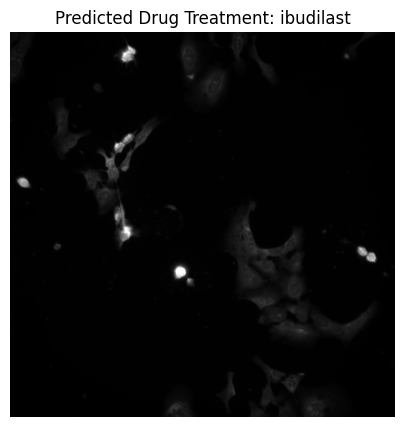

/usr/local/lib/python3.10/dist-packages/cellpose/resnet_torch.py:235: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(filename, map_location=torch.devi

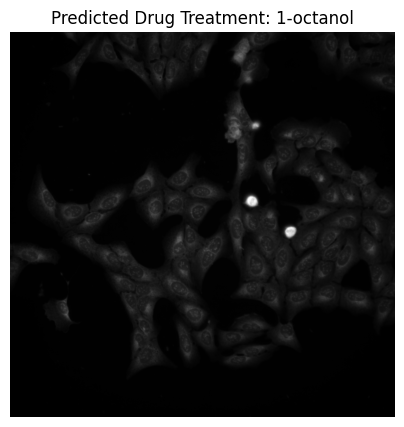

/usr/local/lib/python3.10/dist-packages/cellpose/resnet_torch.py:235: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(filename, map_location=torch.devi

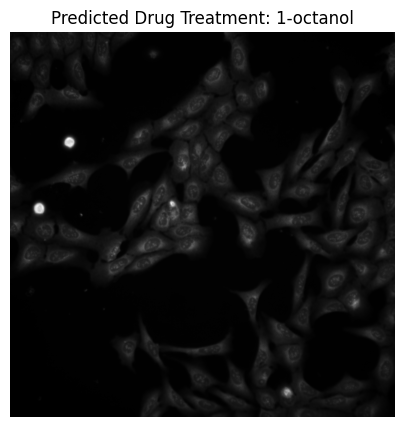

/usr/local/lib/python3.10/dist-packages/cellpose/resnet_torch.py:235: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(filename, map_location=torch.devi

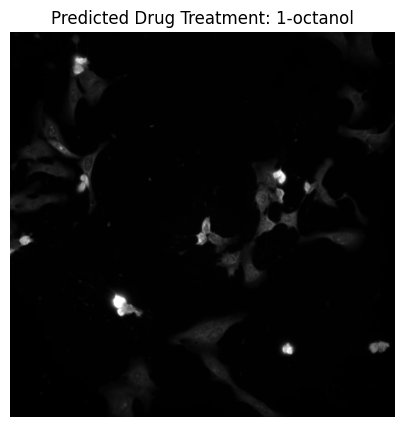

/usr/local/lib/python3.10/dist-packages/cellpose/resnet_torch.py:235: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(filename, map_location=torch.devi

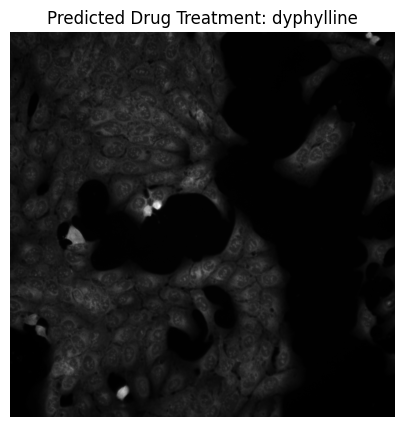

Image: compound-FK866.tiff, Predicted Treatment: ibudilast
Image: compound-DMSO.tiff, Predicted Treatment: 1-octanol
Image: compound-quinidine.tiff, Predicted Treatment: 1-octanol
Image: compound-FK866.tiff, Predicted Treatment: 1-octanol
Image: compound-LY2109761.tiff, Predicted Treatment: dyphylline


In [34]:
if __name__ == "__main__":
    # Paths to test images
    test_image_paths = [
        '/content/drive/MyDrive/STAT5243/Project 2/Data/example_data/r04c08f05p01-compound-FK866.tiff',
        '/content/drive/MyDrive/STAT5243/Project 2/Data/example_data/r04c14f05p01-compound-DMSO.tiff',
        '/content/drive/MyDrive/STAT5243/Project 2/Data/example_data/r06c10f05p01-compound-quinidine.tiff',
        '/content/drive/MyDrive/STAT5243/Project 2/Data/example_data/r12c09f05p01-compound-FK866.tiff',
        '/content/drive/MyDrive/STAT5243/Project 2/Data/example_data/r13c02f05p01-compound-LY2109761.tiff'
    ]

    # Load the trained model and LabelEncoder
    with open('random_forest_model.pkl', 'rb') as file:
        loaded_model = pickle.load(file)

    with open('label_encoder.pkl', 'rb') as file:
        loaded_le = pickle.load(file)

    # Predict and display results
    predictions = predict_and_display_drug_treatments(
        test_image_paths, loaded_model, loaded_le)

    # Print predictions
    for img_path, pred in predictions.items():
        print(f"Image: {img_path[73:]}, Predicted Treatment: {pred}")